In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Flatten
from tensorflow.keras.models import Sequential
from math import sqrt
import math
from tensorflow.keras import regularizers

In [2]:
#Final_Data = pd.read_csv("Final_data_2.csv")
Final_Data = pd.read_csv("SPAIN_data/Final_data_2_new.csv") 
Final_Data = Final_Data.set_index('time')

# Prepare input for LSTM model

In [3]:
def prepare_data_for_lstm(dataframe, first_val_day, first_test_day, days_of_test_set, features, label , window , horizon, missing_days, hours, shape = '1d'):
    X_train = []
    X_val   = []
    X_test  = []
    Y_train = []
    Y_val   = []
    Y_test  = []
    
    days = [ datetime.strptime(item[:10], "%Y-%m-%d") for item in list(dataframe.index)]
    #days = [ datetime.strptime(item.date().strftime("%Y-%m-%d"), "%Y-%m-%d") for item in list(dataframe.index)]
    
    val_date = datetime.strptime(first_val_day, "%Y-%m-%d") 
    id_first_val_day  = days.index(val_date) # Only for this example we need -1. Generally you must delete it

    test_date = datetime.strptime(first_test_day, "%Y-%m-%d")
    id_first_test_day  = days.index(test_date)  # Only for this example we need -1. Generally you must delete it
    
    id_first_train_day = window + missing_days
    
    id_of_end = id_first_test_day + days_of_test_set * hours
        
            
    for i in range( id_first_train_day , id_first_val_day , hours ):
        sample = []
        if shape == '1d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample = sample + instance
        elif shape == '2d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample.append(instance)
        X_train.append(sample)
        Y_train.append( list(dataframe.iloc[i:i+horizon][label].values) )
        
    for i in range( id_first_val_day , id_first_test_day , hours):
        sample = []
        if shape == '1d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample = sample + instance
        elif shape == '2d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample.append(instance)
        X_val.append(sample)
        Y_val.append( list(dataframe.iloc[i:i+horizon][label].values) )
    
    for i in range( id_first_test_day , id_of_end , hours ):
        sample = []
        if shape == '1d':
            for j in range( window + missing_days, missing_days, -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample = sample + instance
        elif shape == '2d':
            for j in range( window + missing_days, missing_days, -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample.append(instance)
        X_test.append(sample)
        Y_test.append( list(dataframe.iloc[i:i+horizon][label].values) ) 
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [4]:
#lstmmm
first_val_day      = '2017-1-1'
first_test_day     = '2018-1-1'
days_of_test_set   = 365

features           = ['total load actual', 
                      'prev_week_load_fd', '2prev_week_load_fd', '3prev_week_load_fd', '4prev_week_load_fd',
                      'humidity_Madrid_fd_n','temp_Madrid_fd_n',#'pressure_Madrid_fd_n','wind_speed_Madrid_fd_n', 
                      #'humidity_Barcelona_fd_n','temp_Barcelona_fd_n',#'pressure_Barcelona_fd_n', 'wind_speed_Barcelona_fd_n', 
                      #'humidity_Valencia_fd_n','temp_Valencia_fd_n',#'pressure_Valencia_fd_n', 'wind_speed_Valencia_fd_n',
                      #'humidity_Seville_fd_n','temp_Seville_fd_n',# 'pressure_Seville_fd_n','wind_speed_Seville_fd_n', 
                      #'humidity_Bilbao_fd_n', 'temp_Bilbao_fd_n',#'pressure_Bilbao_fd_n','humidity_Bilbao_fd_n', 'wind_speed_Bilbao_fd_n', 
                      'weekday_sin_fd','month_sin_fd', 'day_of_year_sin_fd', 'day_of_month_sin_fd',  
                      'weekday_cos_fd','month_cos_fd', 'day_of_year_cos_fd', 'day_of_month_cos_fd', 'weekdays_weekends_fd']
hours              = 24
label              = 'total load actual'
window             = hours * 1
horizon            = hours
black_days         = hours * 1
#date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime
#id_first_test_day  = list(Final_Data.index).index(date)  #find the id of first test day in dataframe 
start_time1 = datetime.now()

X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_data_for_lstm(dataframe= Final_Data, 
                                    first_val_day = first_val_day, first_test_day = first_test_day,
                                    days_of_test_set = days_of_test_set, features = features, label = label, 
                                window = window, horizon = horizon, missing_days = black_days, hours = hours, shape = '2d')
    

    
    
    





start_time2 = datetime.now()
print(start_time2-start_time1)

0:00:21.369437


In [5]:
#create evaluation function to use them in lstms training
#create MAPE and MAE functions
def mean_absolute_percentage_error(y_true, y_pred): 
    mape=np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
def mean_absolute_error(y_true, y_pred): 
    MAE = np.mean(np.abs(y_true-y_pred))
    return MAE
#create a function to evaluate LSTM with MAPE, MAE, RMSE, RRMSE and r2_score
def evaluation_function(y_true, y_pred):

    MAPE=mean_absolute_percentage_error(y_true, y_pred)
    print(f'MAPE: {"{:.5f}".format(MAPE)} %')
    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE : {"{:.5f}".format(MAE)}')

    #RMSE and RRMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {"{:.5f}".format(rmse)}')

    RRMSE = (rmse/np.mean(y_true))*100
    print(f'RRMSE: {"{:.5f}".format(RRMSE)} % ')      
    r2 = r2_score(y_true, y_pred)
    print(f'Test R^2 score: {"{:.5f}".format(r2)}')
    
    return MAPE, MAE, rmse, RRMSE, r2
          
def yearly_error(y_true, y_pred):
    mape = []
    for i in range(0, len(y_pred)):
        for j in range(0, len(y_pred[0])):
            mape.append(mean_absolute_percentage_error(y_true[i][j],y_pred[i][j]))
    #count how many hours has error <=10%, >10% and <15%, >15% and find the percentage of every month
    count1 = 0
    count2 = 0
    count3 = 0
    for item in mape:
        if item <= 10:
            count1 += 1
        elif item <= 15:
            count2 += 1
        else :
            count3 += 1
    print('for the year')
    percentage1 =(count1*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage1)}% has error <=10')
    percentage2 =(count2*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage2)}% has error <=15')
    percentage3 =(count3*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage3)}% has error >15')
          
    return percentage1,percentage2,percentage3

# Built LSTM model

In [6]:
#Adaptive learning rate
#values     = [0.005, 0.001, 0.0005,0.0001]
#epochs     =[30, 65, 100]
len_data = len(X_train)
batch_size = 25


In [7]:
#delete model and # fix random seed for reproducibility
keras.backend.clear_session()
np.random.seed(7)
tf.random.set_seed(7)

In [8]:
#built LSTM model
model = tf.keras.Sequential()
model.add(LSTM(200,return_sequences=True, activation = 'tanh',input_shape=(len(X_train[0]), len(X_train[0][0]))))
model.add(Dropout(0.3))
#model.add(LSTM(200, return_sequences=True))
#model.add(Dropout(0.3))
#model.add(LSTM(200, return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(200, return_sequences=False, activation = 'tanh'))
model.add(Dropout(0.3))
#model.add(Dense(100, activation = 'linear'))
#model.add(Dense(50, activation = 'linear'))
model.add(Dense(horizon, activation = 'linear'))
#model.compile(loss='mape', optimizer= tf.keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.001, nesterov=False))
#model.compile(loss='mape', optimizer=tf.keras.optimizers.RMSprop(learning_rate_fn))#0.001, rho=0.9, epsilon=1e-08, decay=0.0))
#model.compile(loss='mape', optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07))
model.compile(loss='mape', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ) 
#model.compile(loss='mape', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)) 

# Training

Epoch 1/94
29/29 - 3s - loss: 31.3843 - val_loss: 12.2315
Epoch 2/94
29/29 - 2s - loss: 15.4935 - val_loss: 20.7603
Epoch 3/94
29/29 - 2s - loss: 15.3673 - val_loss: 27.9462
Epoch 4/94
29/29 - 2s - loss: 17.2340 - val_loss: 27.1588
Epoch 5/94
29/29 - 2s - loss: 20.2028 - val_loss: 12.4756
Epoch 6/94
29/29 - 2s - loss: 14.4129 - val_loss: 9.1232
Epoch 7/94
29/29 - 2s - loss: 12.5577 - val_loss: 15.2603
Epoch 8/94
29/29 - 2s - loss: 13.2625 - val_loss: 10.9852
Epoch 9/94
29/29 - 2s - loss: 12.7011 - val_loss: 13.2244
Epoch 10/94
29/29 - 2s - loss: 12.5093 - val_loss: 9.8581
Epoch 11/94
29/29 - 2s - loss: 11.2030 - val_loss: 12.1166
Epoch 12/94
29/29 - 2s - loss: 11.2106 - val_loss: 8.1987
Epoch 13/94
29/29 - 2s - loss: 9.8941 - val_loss: 8.9743
Epoch 14/94
29/29 - 2s - loss: 10.4358 - val_loss: 8.0175
Epoch 15/94
29/29 - 2s - loss: 9.1353 - val_loss: 7.7210
Epoch 16/94
29/29 - 2s - loss: 9.4408 - val_loss: 9.2486
Epoch 17/94
29/29 - 2s - loss: 9.0936 - val_loss: 8.2782
Epoch 18/94
29/29 

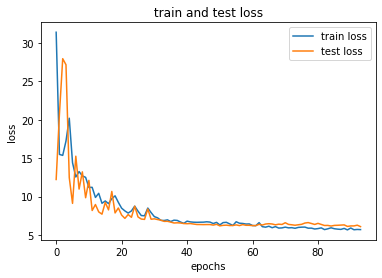

training time is:  0:03:12.599952


In [9]:
# fit network
start_time1 = datetime.now()
history = model.fit(X_train, Y_train, epochs = 94, batch_size=batch_size, validation_data=(X_val, Y_val),verbose=2,shuffle=False)

#if history.history['val_loss'][-1]<valid_loss_min:
    #print('save model...')
    #model.save('best_model_temp.h5')
#plot the losses
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title(' train and test loss ')
plt.legend()
plt.show()

start_time2 = datetime.now()
print('training time is: ', start_time2-start_time1)
 

# Test and evaluation

In [ ]:
# make a prediction and evaluation
Y_pred = model.predict(X_val)


#evaluation
MAPE, MAE, rmse, RRMSE, r2 =  evaluation_function(y_true= Y_val, y_pred= Y_pred)
print("\n")
per1,per2,per3 = yearly_error(y_true = Y_val , y_pred = Y_pred)
print("\n")


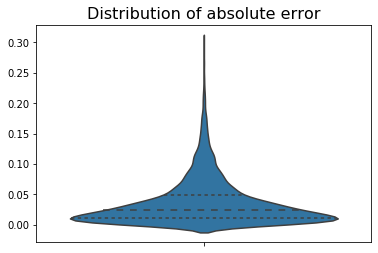

In [15]:
#violin plot for forecasting load
ax = sns.violinplot(y=abs(Y_test-Y_pred), inner='quartile')

ax.set_title('Distribution of absolute error', fontsize=16);

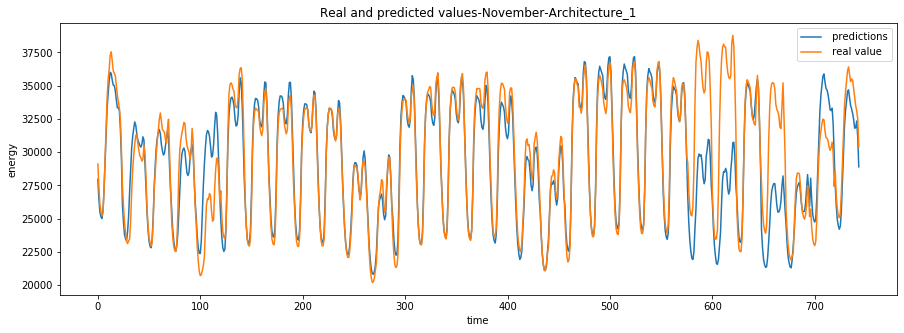

In [16]:
#plot predictions and actual values of load , for January
#select the month 1>Jan, 2>feb, 3>Mar
Month = 11
Ytest= np.array(Y_test)
predictions = Y_pred.flatten()
actual = Ytest.flatten()
ac = actual*41015
pr = predictions*41015
fig = plt.figure(figsize=(15,5))
plt.plot(  pr[31*24*(Month-1):31*24*Month] ,label = " predictions" )
plt.plot(  ac[31*24*(Month-1):31*24*Month] , label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title('Real and predicted values-November-Architecture_1')
plt.legend()
plt.show()

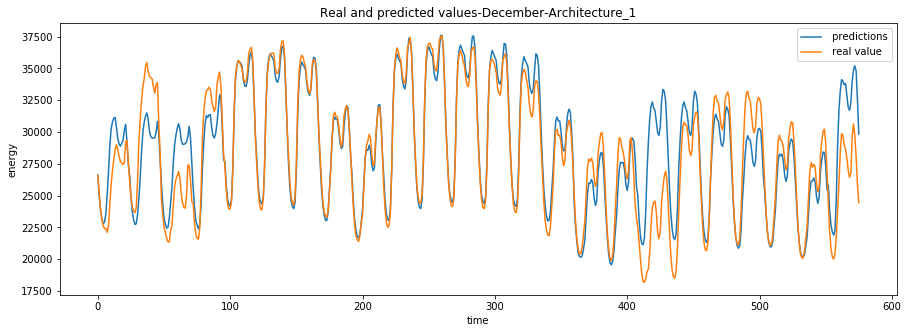

In [17]:
#plot predictions and actual values of load , for January
#select the month 1>Jan, 2>feb, 3>Mar
Month = 12
Ytest= np.array(Y_test)
predictions = Y_pred.flatten()
actual = Ytest.flatten()
ac = actual*41015
pr = predictions*41015
fig = plt.figure(figsize=(15,5))
plt.plot( pr[31*24*(Month-1):31*24*Month] ,label = " predictions" )
plt.plot( ac[31*24*(Month-1):31*24*Month] , label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title('Real and predicted values-December-Architecture_1')
plt.legend()
plt.show()

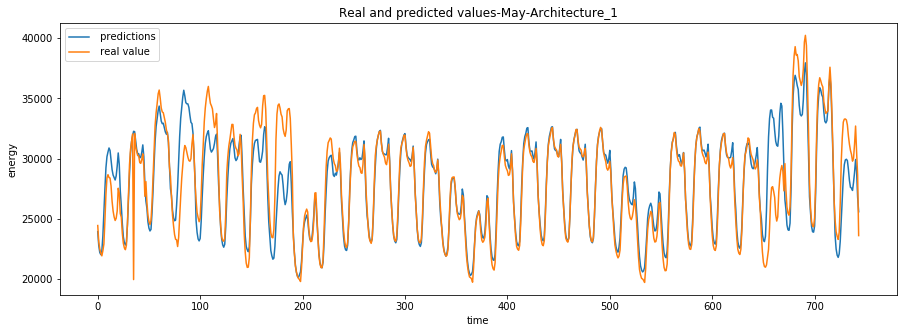

In [18]:
#plot predictions and actual values of load , for January
#select the month 1>Jan, 2>feb, 3>Mar
Month = 5
Ytest= np.array(Y_test)
predictions = Y_pred.flatten()
actual = Ytest.flatten()
ac = actual*41015
pr = predictions*41015
fig = plt.figure(figsize=(15,5))
plt.plot(  pr[31*24*(Month-1):31*24*Month] ,label = " predictions" )
plt.plot(  ac[31*24*(Month-1):31*24*Month] , label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title('Real and predicted values-May-Architecture_1')
plt.legend()
plt.show()

In [23]:
#model.save('model_arch1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_arch1\assets
